HEDGE RATIO (Last 360 bars): 1.190535438294757


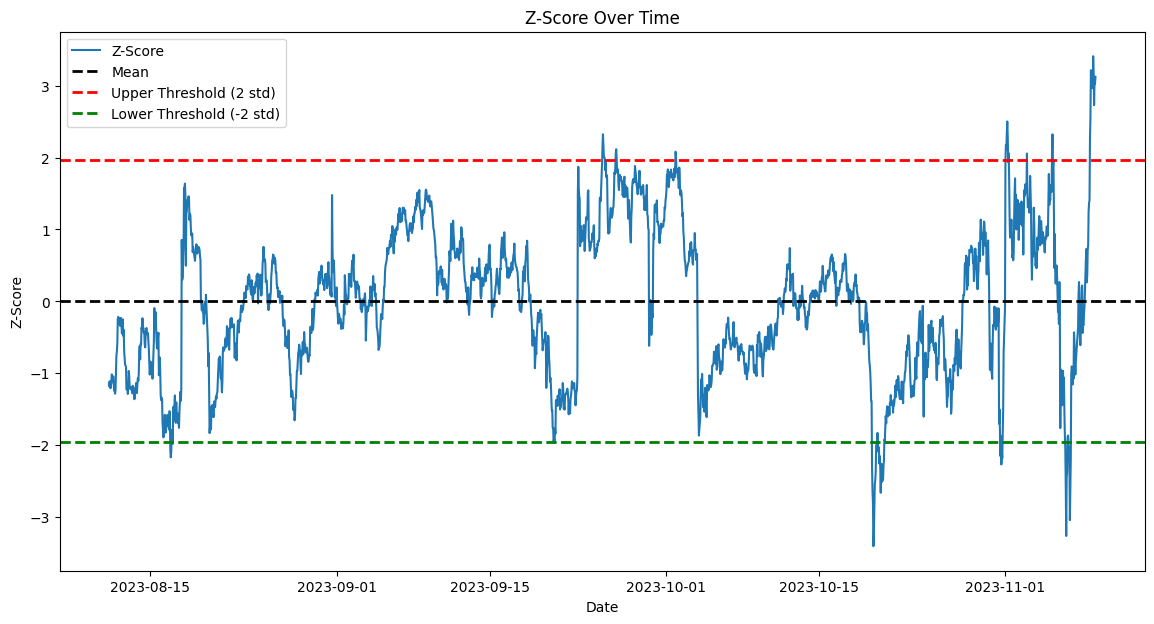

ADF Statistic: -4.235617084431802
p-value: 0.0005731652342088653
Critical Values:
	1%: -3.4334137212590194
	5%: -2.8628934347449033
	10%: -2.567490502788733
The spread is cointegrated at a 5% significance level.
Mean z-score: 6.579099405186112e-17
Standard deviation of z-score: 1.0
Entry Threshold: 1.0
Exit Threshold: 6.579099405186112e-17


In [10]:
import logging
import pandas as pd
import ccxt
from datetime import datetime
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt


def fetch_prices(binance, symbol_one, symbol_two, look_back_days=90): 
    # Prepare empty dataframe for results
    df_final = pd.DataFrame()
    
    # Calculate the end timestamp for the data fetching
    end_timestamp = binance.milliseconds()
    since_timestamp = end_timestamp - look_back_days * 24 * 60 * 60 * 1000 
    
    while since_timestamp < end_timestamp:
        try:
            # Fetch OHLCV data
            ohlcv_theta = binance.fetch_ohlcv(symbol_two, '1h', since=since_timestamp, limit=1000)
            ohlcv_xrp = binance.fetch_ohlcv(symbol_one, '1h', since=since_timestamp, limit=1000)
            
            # Create temporary dataframes to hold fetched data
            df_theta_temp = pd.DataFrame(ohlcv_theta, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])
            df_xrp_temp = pd.DataFrame(ohlcv_xrp, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])
            
            # Merge dataframes
            df_temp = pd.merge(df_theta_temp[['timestamp', 'close']], df_xrp_temp[['timestamp', 'close']], on='timestamp', how='inner')
            df_temp.columns = ['timestamp', symbol_two, symbol_one]
            
            # Concatenate with the final dataframe
            df_final = pd.concat([df_final, df_temp])
            
            # Update the since_timestamp to the last timestamp fetched
            since_timestamp = df_final['timestamp'].max() + (60 * 60 * 1000)  # Add one hour

        except Exception as e:
            logging.error(f"Error in fetching prices: {e}")
            break
    
    # Remove duplicates and sort the dataframe
    df_final.drop_duplicates(subset='timestamp', keep='first', inplace=True)
    df_final.sort_values(by='timestamp', inplace=True)
    
    return df_final


def check_cointegration(prices, symbol_one, symbol_two, lookback_window):
    # Select only the most recent 'lookback_window' observations
    recent_prices = prices.tail(lookback_window)

    X_with_const = sm.add_constant(recent_prices[symbol_one])

    # Perform regression to find hedge ratio using the recent data
    model = sm.OLS(recent_prices[symbol_two], X_with_const).fit()
    hedge_ratio = model.params[symbol_one]

    print(f"HEDGE RATIO (Last {lookback_window} bars): {hedge_ratio}")
    
    # Calculate the spread
    # The spread is now symbol_two minus the hedge ratio times symbol_one
    prices['spread'] = prices[symbol_two] - hedge_ratio * prices[symbol_one]
    
    # Calculate the z-score of the spread
    spread_mean = prices['spread'].mean()
    spread_std = prices['spread'].std()
    prices['z_score'] = (prices['spread'] - spread_mean) / spread_std

    prices.to_csv("coint.csv", index=True)
    
    # Perform Augmented Dickey-Fuller test on the spread
    adf_result = adfuller(prices['spread'])

    # Plot the z_score
    plt.figure(figsize=(14, 7))
    plt.plot(prices.index, prices['z_score'], label='Z-Score')
    plt.axhline(0, color='black', linestyle='--', linewidth=2, label='Mean')
    plt.axhline(1.96, color='red', linestyle='--', linewidth=2, label='Upper Threshold (2 std)')
    plt.axhline(-1.96, color='green', linestyle='--', linewidth=2, label='Lower Threshold (-2 std)')
    plt.title('Z-Score Over Time')
    plt.xlabel('Date')
    plt.ylabel('Z-Score')
    plt.legend(loc='best')
    plt.show()
    
    print(f"ADF Statistic: {adf_result[0]}")
    print(f"p-value: {adf_result[1]}")
    print('Critical Values:')
    for key, value in adf_result[4].items():
        print(f'\t{key}: {value}')
    
    if adf_result[1] < 0.05:
        print("The spread is cointegrated at a 5% significance level.")
        return True
    else:
        print("The spread is not cointegrated.")
        return False


# Set up exchange connection
binance = ccxt.binance()

# Fetch prices
prices = fetch_prices(binance, "XRPUSDT", "THETAUSDT", look_back_days=90)

# Convert timestamps to datetime format and set as index
prices['time'] = pd.to_datetime(prices['timestamp'], unit='ms')
prices.set_index('time', inplace=True)


# Check if the series are cointegrated
cointegrated = check_cointegration(prices, 'XRPUSDT', 'THETAUSDT', 360)

# If cointegrated, we can move on to determine suitable z-score thresholds
# These would typically be determined based on historical data and the desired frequency of trading signals
if cointegrated:
    # Analyze the historical distribution of the z-score
    mean_z_score = prices['z_score'].mean()
    std_z_score = prices['z_score'].std()
    
    # Example thresholds for entry and exit
    entry_threshold = mean_z_score + std_z_score
    exit_threshold = mean_z_score
    
    print(f"Mean z-score: {mean_z_score}")
    print(f"Standard deviation of z-score: {std_z_score}")
    print(f"Entry Threshold: {entry_threshold}")
    print(f"Exit Threshold: {exit_threshold}")



